Atonia Andall
816009278

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import LabelEncoder

### Forecasting

In [2]:
energy=pd.read_csv('energydata.csv').filter(["day","energy_sum"])
energy["day"]=pd.to_datetime(energy["day"]).dt.date
weather=pd.read_csv("weather_daily_darksky.csv").filter(["temperatureHigh","time"])
weather["time"]=pd.to_datetime(weather["time"]).dt.date

In [3]:
energy=energy.groupby("day", as_index=False)["energy_sum"].sum()

In [4]:
weather=weather.groupby("time", as_index=False)["temperatureHigh"].max()

In [5]:
print(energy.describe())
print(weather.describe())

       energy_sum
count  828.000000
mean   463.914829
std    144.837611
min      5.213000
25%    371.531250
50%    438.524500
75%    573.639000
max    888.870000
       temperatureHigh
count       879.000000
mean         13.548658
std           6.263454
min          -0.810000
25%           9.215000
50%          12.460000
75%          17.920000
max          32.400000


Getting rid of outliers using z index. 

In [6]:
from scipy import stats

weather["temperatureHigh"]= np.where( (np.abs(stats.zscore( weather["temperatureHigh"])) >3), np.nan, weather.temperatureHigh) 


energy["energy_sum"]= np.where( (np.abs(stats.zscore( energy["energy_sum"])) >3), np.nan,  energy.energy_sum) 


In [7]:
weather["temperatureHigh"]=weather['temperatureHigh'].fillna(weather.groupby(pd.to_datetime(weather["time"]).dt.to_period("M"))['temperatureHigh'].transform('mean'))
#fill empties with that month's average.  if unavailable, fill with the year's average
energy["energy_sum"]=energy['energy_sum'].fillna(energy.groupby(pd.to_datetime(energy["day"]).dt.to_period("M"))['energy_sum'].transform('mean'))
energy["energy_sum"]=energy['energy_sum'].fillna(energy.groupby(pd.to_datetime(energy["day"]).dt.year)['energy_sum'].transform('mean'))


In [8]:
print(energy.describe())
print(weather.describe())

       energy_sum
count  828.000000
mean   468.359627
std    134.620873
min     29.975000
25%    371.597250
50%    438.897000
75%    573.917501
max    888.870000
       temperatureHigh
count       879.000000
mean         13.540666
std           6.243824
min          -0.810000
25%           9.215000
50%          12.460000
75%          17.920000
max          32.160000


In [9]:
ene=energy.set_index('day')
ene.sort_index(inplace=True)

wea=weather.set_index('time')
wea.sort_index(inplace=True)

In [10]:
print(pd.isnull(energy["energy_sum"]).sum())
print(pd.isnull(weather["temperatureHigh"]).sum())

0
0


In [11]:
print(ene)
print(wea)

            energy_sum
day                   
2011-11-24  222.394696
2011-11-25  222.394696
2011-11-26  222.394696
2011-11-27  222.394696
2011-11-28  222.394696
...                ...
2014-02-24  523.938001
2014-02-25  509.207000
2014-02-26  477.257000
2014-02-27  582.854001
2014-02-28  575.688926

[828 rows x 1 columns]
            temperatureHigh
time                       
2011-11-01            15.57
2011-11-02            15.06
2011-11-03            17.41
2011-11-04            15.54
2011-11-05            13.94
...                     ...
2014-03-26             8.48
2014-03-27            10.04
2014-03-28            12.43
2014-03-29            18.47
2014-03-30            19.82

[879 rows x 1 columns]


We join the two datasets on the "date" and "time" fields as these fields are similar in both datasets and can be used to create a unique index for each item. 

In [12]:
#5
df=weather.merge(energy, how='outer',left_on="time", right_on="day" )
df

,time,temperatureHigh,day,energy_sum
0,2011-11-01,15.57,NaN,NaN
1,2011-11-02,15.06,NaN,NaN
2,2011-11-03,17.41,NaN,NaN
3,2011-11-04,15.54,NaN,NaN
4,2011-11-05,13.94,NaN,NaN
...,...,...,...,...
876,2014-03-28,12.43,NaN,NaN
877,2014-03-29,18.47,NaN,NaN
878,2014-03-30,19.82,NaN,NaN
879,NaN,NaN,2012-10-28,624.949


In [13]:
df["day"]=df["day"].fillna(df["time"])
df=df.drop("time", axis=1)
df["day"].describe()

count            881
unique           881
top       2013-06-22
freq               1
Name: day, dtype: object

We fill missing values with the average value for that particular month.

In [14]:
df["temperatureHigh"]=df['temperatureHigh'].fillna(df.groupby(pd.to_datetime(df["day"]).dt.to_period("M"))['temperatureHigh'].transform('mean'))

In [15]:
df["energy_sum"]=df['energy_sum'].fillna(df.groupby(pd.to_datetime(df["day"]).dt.to_period("M"))['energy_sum'].transform('mean'))

In [16]:
print(df.describe())
print(df["day"].describe())

       temperatureHigh  energy_sum
count       881.000000  851.000000
mean         13.543341  461.711926
std           6.237292  138.654893
min          -0.810000   29.975000
25%           9.220000  366.155000
50%          12.480000  434.633000
75%          17.920000  572.573000
max          32.160000  888.870000
count            881
unique           881
top       2013-06-22
freq               1
Name: day, dtype: object


There is still some missing values.  Presumably there is no data for that month. We will fill those with their year's mean

In [17]:
df["energy_sum"]=df['energy_sum'].fillna(df.groupby(pd.to_datetime(df["day"]).dt.year)['energy_sum'].transform('mean'))

In [18]:
df.set_index('day', inplace=True)
df.sort_index(inplace=True)

In [19]:
df

,temperatureHigh,energy_sum
day,,
2011-11-01,15.57,222.394696
2011-11-02,15.06,222.394696
2011-11-03,17.41,222.394696
2011-11-04,15.54,222.394696
2011-11-05,13.94,222.394696
...,...,...
2014-03-26,8.48,571.701490
2014-03-27,10.04,571.701490
2014-03-28,12.43,571.701490


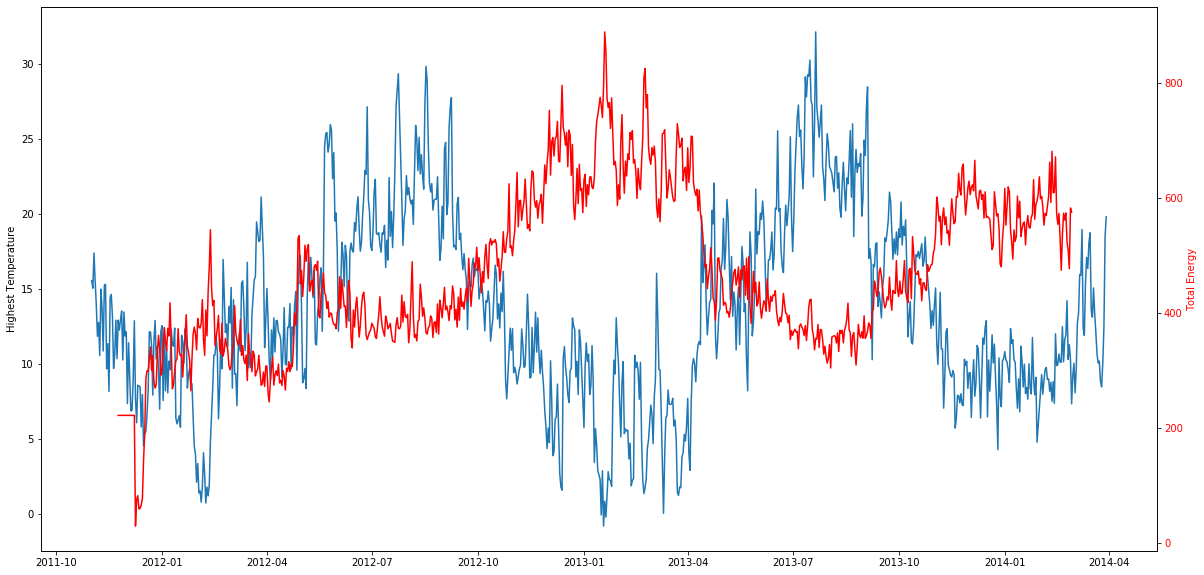

In [20]:
#1 and 2
fig = plt.figure(figsize=(20,10),linewidth=5)
ax1 = fig.add_subplot()
ax1.plot(wea["temperatureHigh"])
ax1.set_ylabel('Highest Temperature')

ax2 = ax1.twinx()
ax2.plot(ene["energy_sum"], 'r-')
ax2.set_ylabel('Total Energy', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

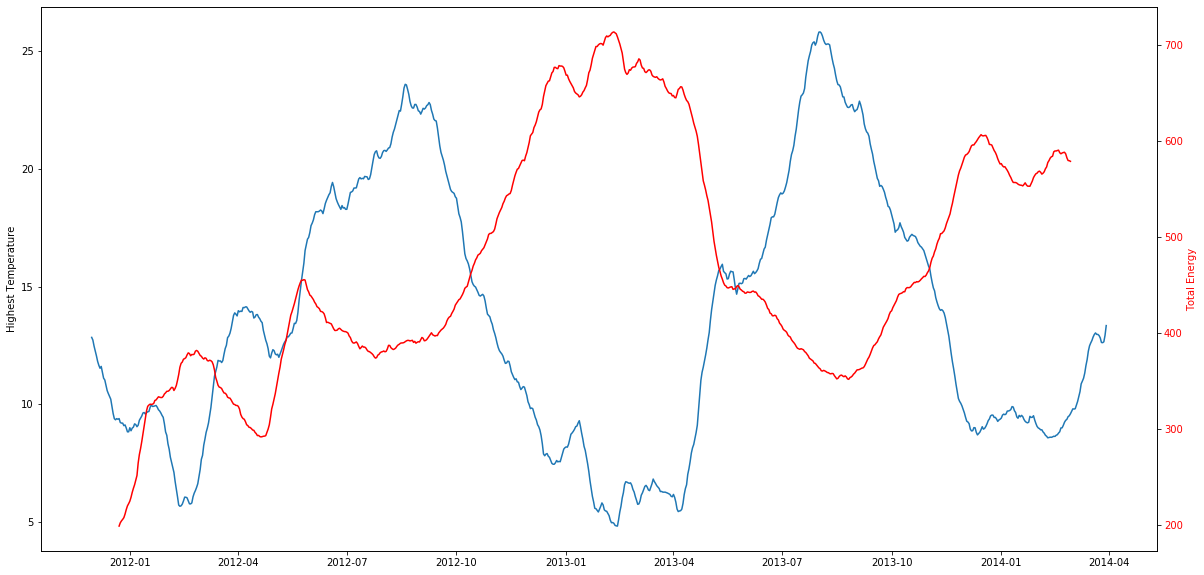

In [21]:
fig = plt.figure(figsize=(20,10), linewidth=5)
ax1 = fig.add_subplot()
ax1.plot(wea["temperatureHigh"].rolling(30).mean())
ax1.set_ylabel('Highest Temperature')

ax2 = ax1.twinx()
ax2.plot(ene["energy_sum"].rolling(30).mean(), 'r-')
ax2.set_ylabel('Total Energy', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

From observing the graph, we can see that temperature and energy used have an inverse relation.  Dips in energy use coincide with high temperatures. Energy use typically begin to rise around October and spike in the period between Jauary and April.  Energy use dips around April till it starts to rise in October.  However, energy use seems to be generally increasing over the years

The dips and rise in energy use may coincide with the change in seasons.  High energy use coincides with colder months and winter (where highest temperature is lowest).  The population is most likely using heating in their homes.  After April is typically spring and so the population would use less heat as the temperature rises.

There was a spike in energy use in 2013 which seems to coincide with a long dip in temperature.  In 2012, the dip in temperature was for a shorter time and so the energy use spiked for a shorter time.  In 2014, the temperature dip is not as pronounced as in 2013 and energy use, in turn, seems to be less than in 2013.

Text(0.5, 0, 'Month')

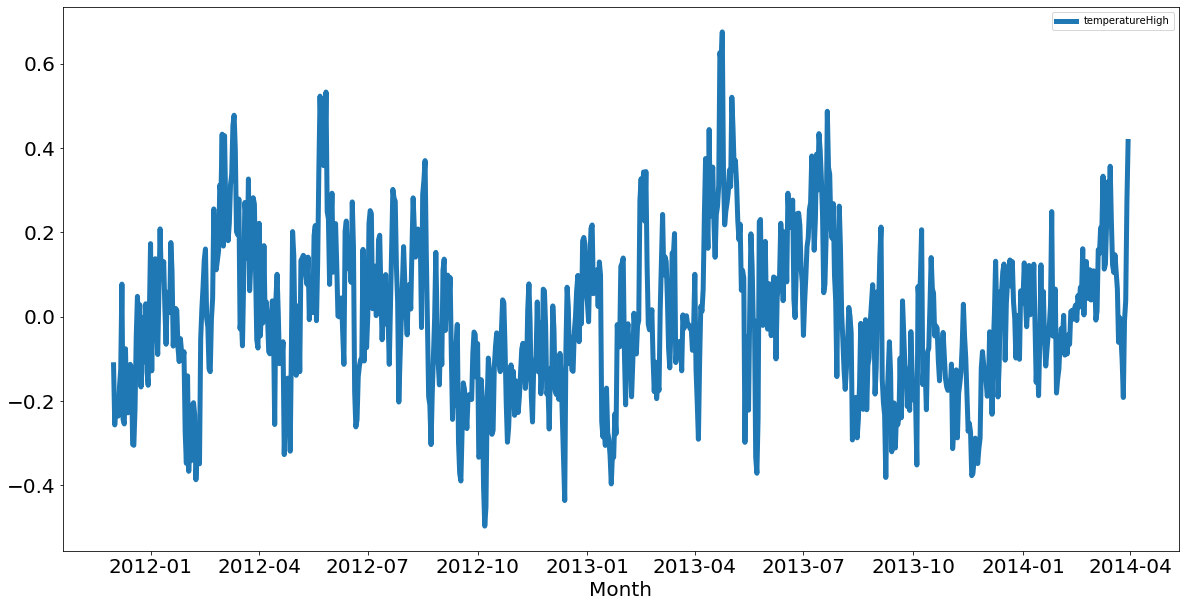

In [22]:
wea.rolling(30).mean().diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Month', fontsize=20)

Temperatures spike the most during the March to July period.  There also tends to be a large dip in temperature around April.  Temperatures tend to be lower during the October to January period.

Text(0.5, 0, 'Month')

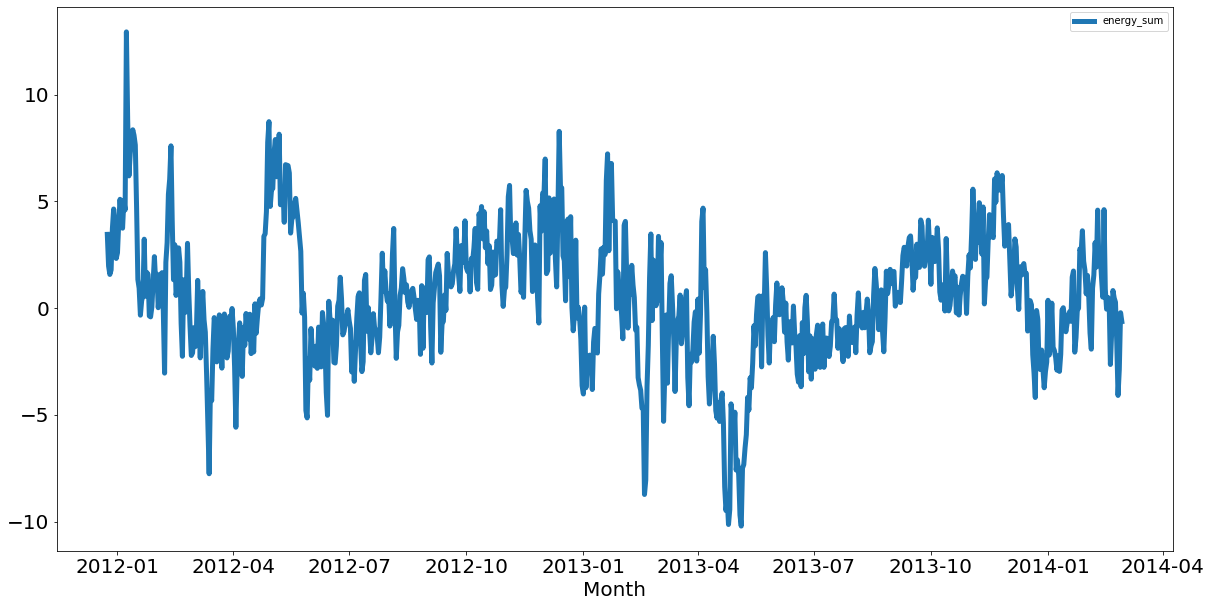

In [23]:
ene.rolling(30).mean().diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Month', fontsize=20)

Energy use over the time period has sharp rises and dips in the period right after April.  This could be because, as temperatures get warmer in the 2012 period, more person opted to use airconditiong while in the 2013 period, people opted to ddo without airconditioning or heating.  There tends to be a gradual rise in energy use from the periods of July to January.  This may be because, temperatures tend to gradually fall in the same period so persons are beginning to use  their heating systems.

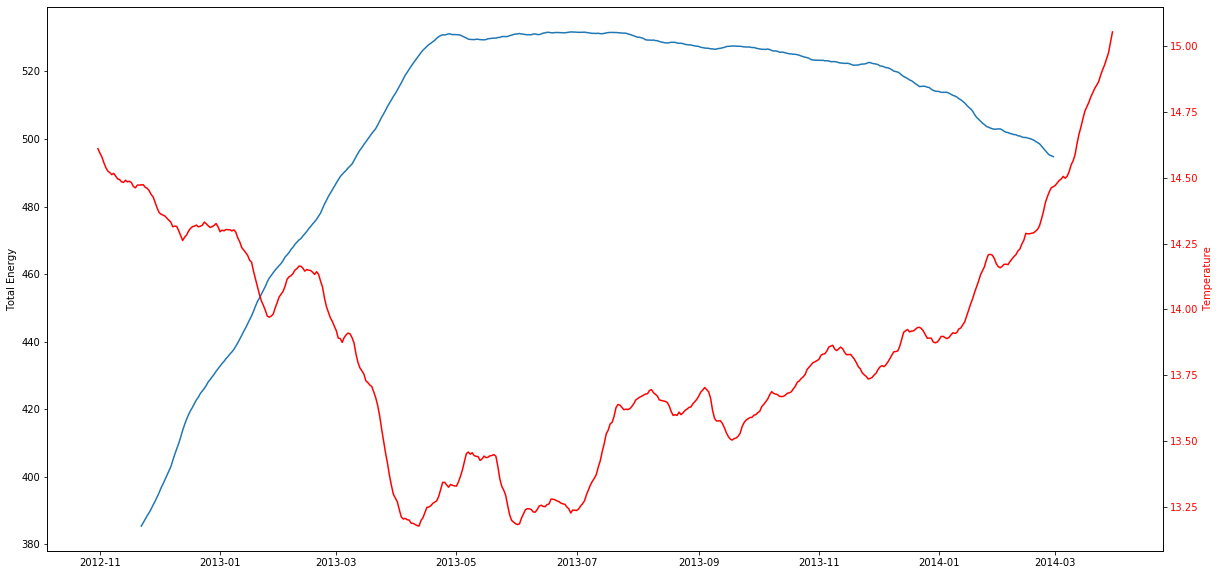

In [24]:
fig = plt.figure(figsize=(20,10), linewidth=5)
ax1 = fig.add_subplot()
ax1.plot(ene["energy_sum"].rolling(365).mean())
ax1.set_ylabel('Total Energy')

ax2 = ax1.twinx()
ax2.plot(wea["temperatureHigh"].rolling(365).mean(), 'r-')
ax2.set_ylabel('Temperature', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')


There seems to be a rise in energy use over the years.  Energy use peaked in early 2013 and remained relatively steady from then onwards.  2013 coincides with the lowest average temperatures

In [25]:
#3

wea.index = pd.to_datetime(wea.index)
train = wea[wea.index.year < 2014]
test = wea[wea.index.year == 2014]

train.head()


,temperatureHigh
time,
2011-11-01,15.57
2011-11-02,15.06
2011-11-03,17.41
2011-11-04,15.54
2011-11-05,13.94


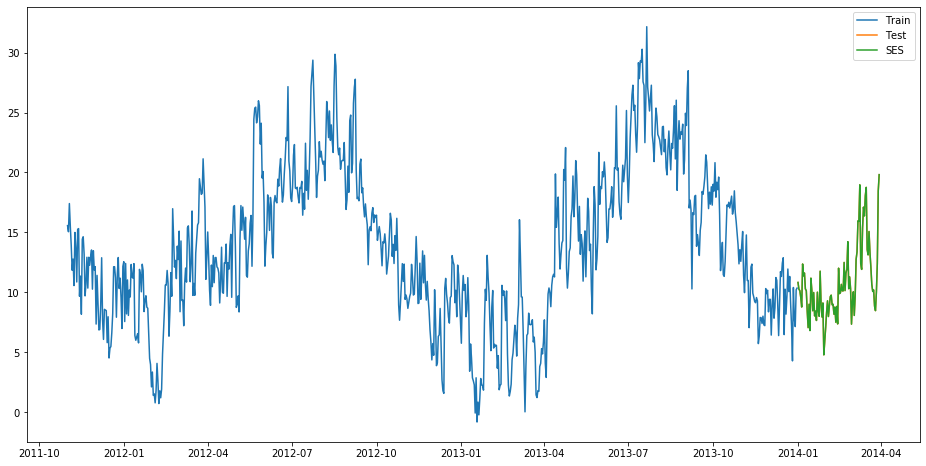

0.0


In [26]:
y_hat_avg = test.copy()
#an alpha value of one results in a rms of 0
y_hat_avg['SES'] = test.ewm(alpha=1).mean()
plt.figure(figsize=(16,8))
plt.plot(train['temperatureHigh'], label='Train')
plt.plot(test['temperatureHigh'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(test["temperatureHigh"], y_hat_avg.SES))
print(rms)

In [27]:
#4
ene.index = pd.to_datetime(ene.index)
train = ene[ene.index.year < 2014]
test = ene[ene.index.year == 2014]

ene.head()

,energy_sum
day,
2011-11-24,222.394696
2011-11-25,222.394696
2011-11-26,222.394696
2011-11-27,222.394696
2011-11-28,222.394696


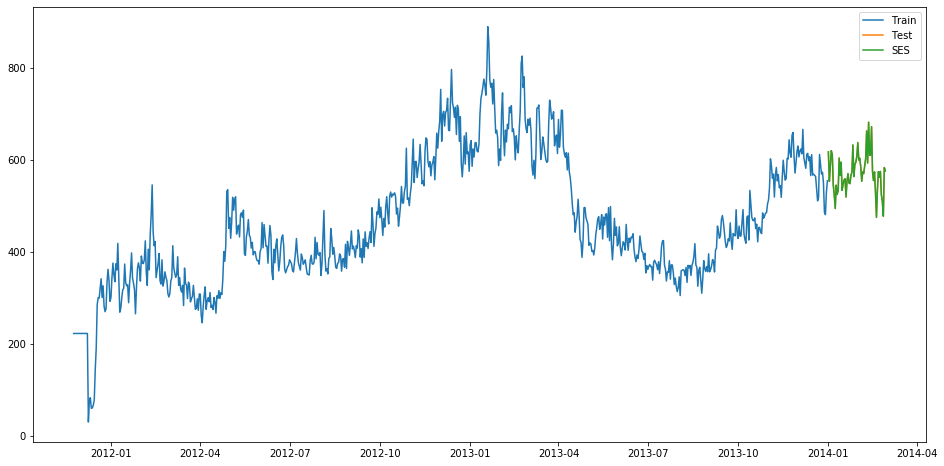

0.0


In [28]:
y_hat_avg = test.copy()
#an alpha value of one results in a rms of 0
y_hat_avg['SES'] = test.ewm(alpha=1).mean()
plt.figure(figsize=(16,8))
plt.plot(train['energy_sum'], label='Train')
plt.plot(test['energy_sum'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()
rms = sqrt(mean_squared_error(test["energy_sum"], y_hat_avg.SES))
print(rms)

Text(0, 0.5, 'Total Energy')

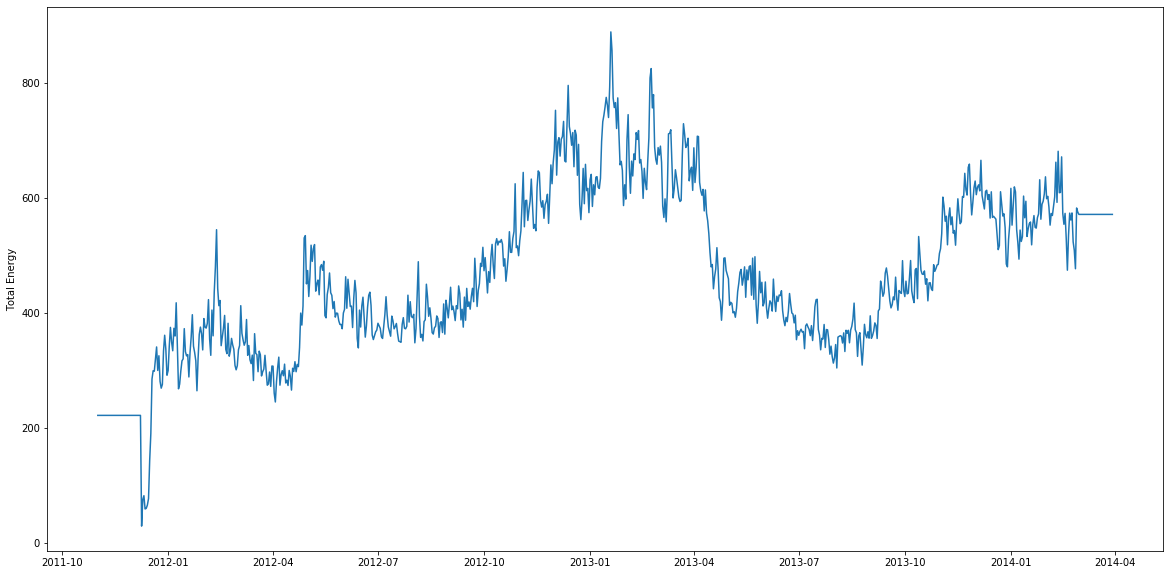

In [29]:
#6
fig = plt.figure(figsize=(20,10), linewidth=5)
ax1 = fig.add_subplot()
ax1.plot(df["energy_sum"])
ax1.set_ylabel('Total Energy')

Text(0, 0.5, 'Highest Temperature')

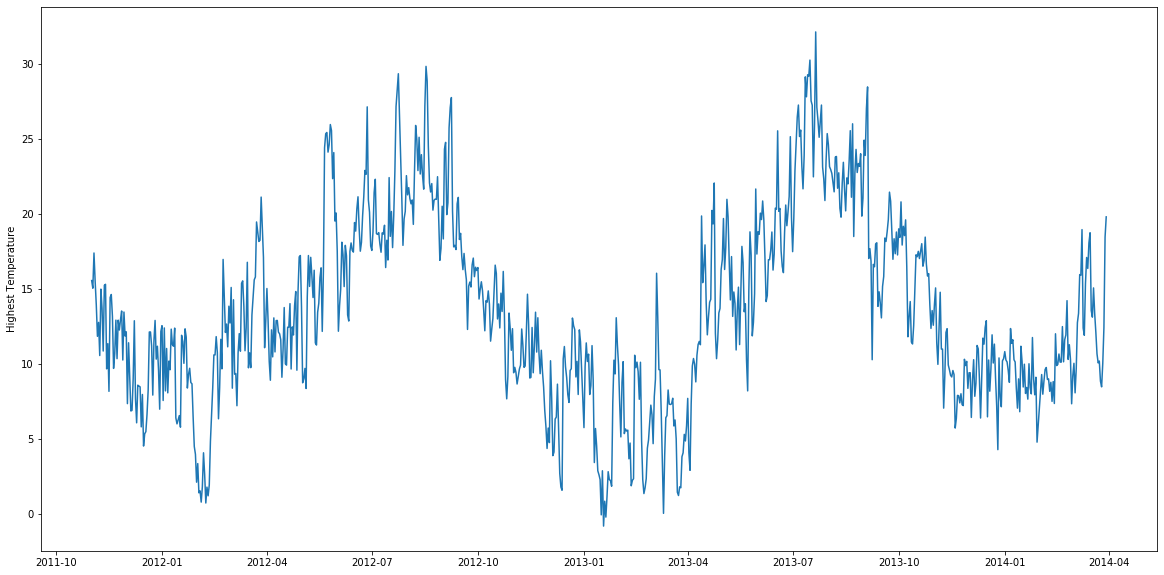

In [30]:
fig = plt.figure(figsize=(20,10), linewidth=5)
ax1 = fig.add_subplot()
ax1.plot(df["temperatureHigh"])
ax1.set_ylabel('Highest Temperature')

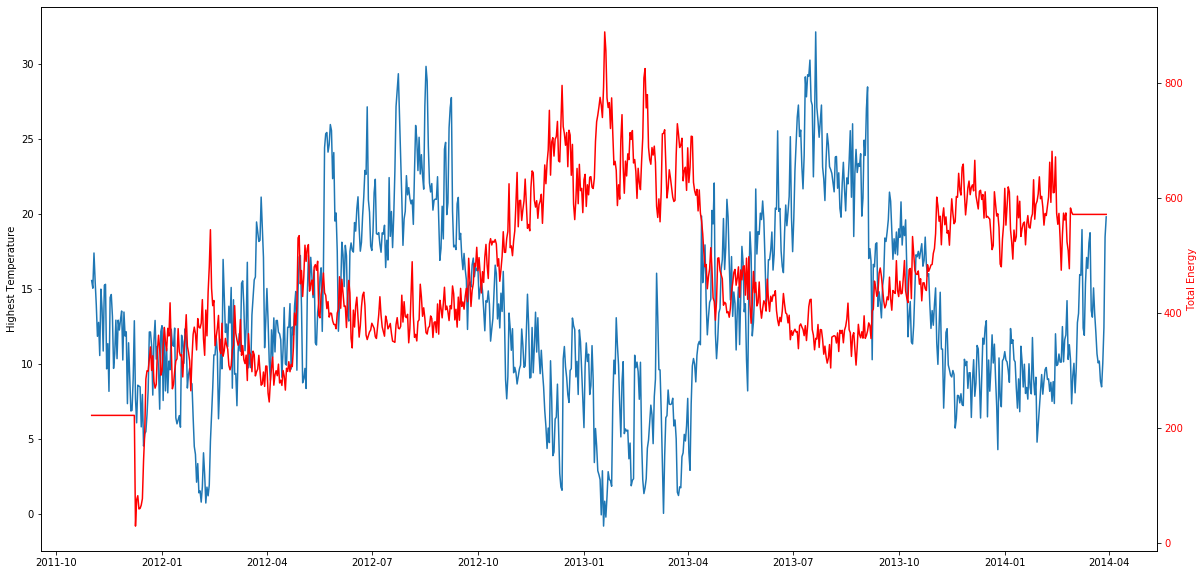

In [31]:
fig = plt.figure(figsize=(20,10),linewidth=5)
ax1 = fig.add_subplot()
ax1.plot(df["temperatureHigh"])
ax1.set_ylabel('Highest Temperature')

ax2 = ax1.twinx()
ax2.plot(df["energy_sum"], 'r-')
ax2.set_ylabel('Total Energy', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

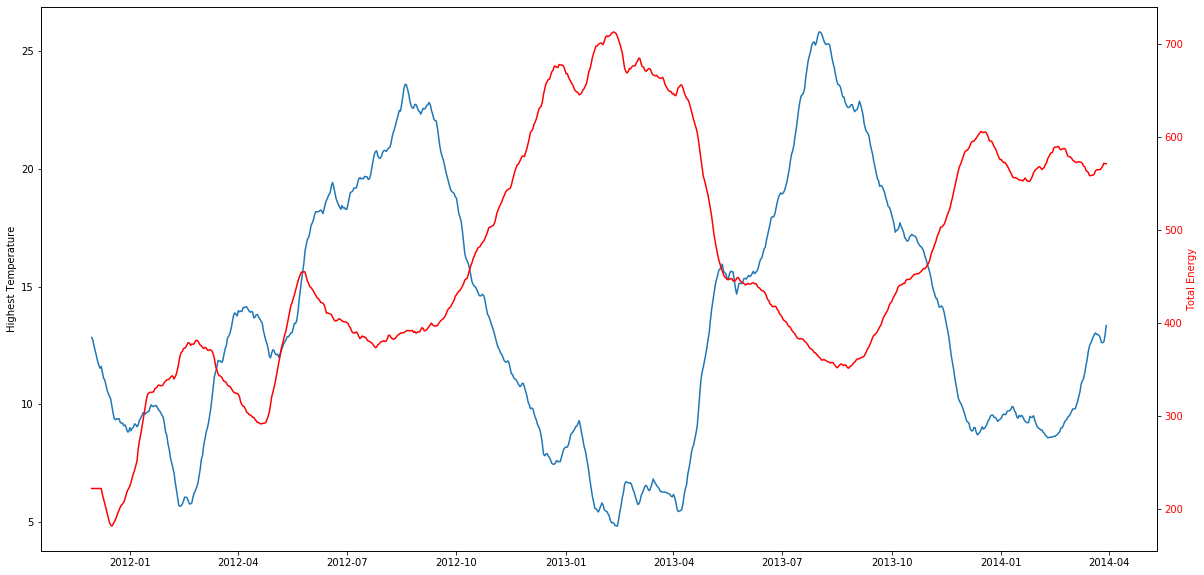

In [32]:
fig = plt.figure(figsize=(20,10),linewidth=5)
ax1 = fig.add_subplot()
ax1.plot(df["temperatureHigh"].rolling(30).mean())
ax1.set_ylabel('Highest Temperature')

ax2 = ax1.twinx()
ax2.plot(df["energy_sum"].rolling(30).mean(), 'r-')
ax2.set_ylabel('Total Energy', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

The observations between datasets are almost identical.  This is because essentially the data is the same.  The main difference is because of the cleaning of data, the times the graph span across are now equal. The edges of the graph where data has been substituted with some mean are flat compared to the rest of the graph as possibly whole months have been filled with some average.

### Prediction

In [33]:
df.describe()

,temperatureHigh,energy_sum
count,881.000000,881.000000
mean,13.543341,465.457314
std,6.237292,137.724919
min,-0.810000,29.975000
25%,9.220000,368.361000
50%,12.480000,439.470000
75%,17.920000,571.701490
max,32.160000,888.870000


We will use the percentiles to rank the data.  Where above the 2nd percentile is high and below it is low.  If we were using more than 2 rankings, we can call under the the 1st percentile low, bewteen the 1st and 3rd percentile average, and above the third percentile high. The main difference in the data is seen where data was missing for certain dates in one of the datasets, such as March in the enrgy dataset, where it was filled with an average value.

In [34]:
df["consumption"]=np.where(df['energy_sum']>df['energy_sum'].median(), 'High', 'Low')
df

,temperatureHigh,energy_sum,consumption
day,,,
2011-11-01,15.57,222.394696,Low
2011-11-02,15.06,222.394696,Low
2011-11-03,17.41,222.394696,Low
2011-11-04,15.54,222.394696,Low
2011-11-05,13.94,222.394696,Low
...,...,...,...
2014-03-26,8.48,571.701490,High
2014-03-27,10.04,571.701490,High
2014-03-28,12.43,571.701490,High


In [35]:
le = LabelEncoder()
df["consumption"]=le.fit_transform(df["consumption"])
df["year"]=pd.to_datetime(df.index).year
df.index = pd.to_datetime(df.index)
train = df[df.index.year < 2014]
test = df[df.index.year == 2014]

We are trying to predict energy consumption, if it will be low or high.  Enery sum is the energy consumption, and so will not be used.  Consumption will be used instead as the predicted value.  We will make our predictions based on the temperature and year as, from the graph, temperature seems to directly impact energy consumption and the year.

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve

In [37]:
x_test=test.drop(["energy_sum","consumption"], axis=1).copy().values
y_test=test["consumption"].values

x_train=train.drop(["energy_sum","consumption"], axis=1).copy().values
y_train=train["consumption"].values

In [38]:
gaussian = GaussianNB()
gaussian.fit(x_train, y_train)
y_pred = gaussian.predict(x_test)
acc_gaussian = round(accuracy_score(y_test,y_pred) * 100, 2)
print("Accuracy",acc_gaussian)
print(confusion_matrix(y_test,y_pred))

Accuracy 86.52
[[77 12]
 [ 0  0]]
